In [1]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import yaml
import pandas as pd
import os

from scipy.signal import convolve2d, convolve
from scipy.signal.windows import blackman, gaussian
import copy

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from collections import defaultdict
from joblib import Parallel, delayed
from umap import UMAP

from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn
from torch import optim
from torch import autograd

from train_utils import get_capacity, plot_weights_hist, train
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         get_pred_index, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from models_utils import init_weights, \
                         universal_approximator, \
                         dJ_criterion, \
                         gained_function, \
                         adjust_learning_rate, \
                         compute_joint_probabilities, \
                         tsne_loss,\
                         tsne_criterion

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
%autoreload 2

# Load data 

In [2]:
# n_pc = 2
# n_emb = 10
# cov = np.array([[1, 0.89],
#                 [0.89, 1]])
# W = np.random.randn(n_pc, n_emb)
# W /= np.linalg.norm(W, axis=0, keepdims=True)

# input_parameters = {'generator': make_random_affine, #make_s_curve, 
#                     'generator_kwargs': {'n_samples':1000, 'noise':1e-2, 'cov':cov, 'W':W}, # 1e-1
#                     'normalize':False,
#                     'unsupervised':False,
#                     'scaler':StandardScaler()} # SCALER


# inpt, outpt = create_data()
# inpt_test, outpt_test = create_data()

In [3]:
# SCALER = StandardScaler() 
# corr_thresh = 0.6
# angle = np.random.random_sample()*2*np.pi 
# distance = 0.5 + np.random.random_sample()
# corr = corr_thresh + min(0.99-corr_thresh, np.random.random_sample())

# input_parameters = {'generator': make_kurtosis_bicluster, #make_s_curve, 
#                     'generator_kwargs': {'n_samples':1000, 
#                                          'distance':distance, 
#                                          'angle':angle,
#                                          'corr':corr}, # 1e-1
#                     'normalize':True,
#                     'unsupervised':False,
#                     'scaler':SCALER,
#                     'whiten':True
#                    }

# inpt, outpt = create_data(**input_parameters)

# inpt_test, outpt_test = create_data(**input_parameters)

In [4]:
# plt.scatter(inpt[0], inpt[1], c=outpt[0])
# plt.scatter(inpt_test[0], inpt_test[1], c=outpt_test[0])

In [5]:
SCALER = MinMaxScaler((-1,1))

input_parameters = {'generator': make_s_curve, #make_s_curve, 
                    'generator_kwargs': {'n_samples':1000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':False,
                    'scaler':SCALER,
                    'use_outpt_color':True} # SCALER

create_data = DataGenerator(**input_parameters)

inpt, outpt, color = create_data()
inpt_test, outpt_test, color_test = create_data()

In [12]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(inpt.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()

In [13]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(np.concatenate([inpt, inpt_test], axis=1).T, columns=['x','y', 'z'])

# df['target'] = np.concatenate([np.zeros((inpt.shape[1])), 
#                                np.ones((inpt_test.shape[1]))])

# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

# fig.show()

# PCA

In [14]:
N_CYCLES = 3
data = [create_data()  for _ in range(N_CYCLES)]
inpt_data = np.concatenate([d[0] for d in data],-1)
outpt_data = np.concatenate([d[1] for d in data],-1)

3


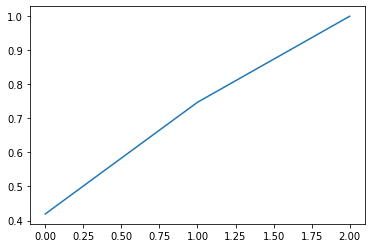

In [9]:
pca = PCA()
Z_pca = pca.fit_transform(inpt_data.T)
pca_ev = np.cumsum(pca.explained_variance_ratio_)
print((np.arange(1,inpt_data.shape[0]+1)[pca_ev > 0.99])[0])
plt.plot(pca_ev)
plt.show()

In [79]:
# plt.scatter(Z_pca[:,0], Z_pca[:,1], c=outpt_data[0])
# plt.colorbar()

In [255]:
# Z_pca_test = pca.transform(inpt_test.T)
# plt.scatter(Z_pca_test[:,0], Z_pca_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [256]:
# umap = UMAP(n_components=2, n_neighbors=50, n_jobs=1)
# Z = umap.fit_transform(inpt_data.T)
# Z_test = umap.transform(inpt_test.T)

In [257]:
# plt.scatter(Z[:,0], Z[:,1], c=outpt_data[0])
# plt.colorbar()

In [258]:
# plt.scatter(Z_test[:,0], Z_test[:,1], c=outpt_test[0])
# plt.colorbar()

In [259]:
# Q_loc_val_UMAP, Q_glob_val_UMAP = calculate_Q_metrics(inpt_test.T, Z_test)

In [260]:
# Q_loc_val_UMAP, Q_glob_val_UMAP

In [261]:
# X,y = inpt_data.T, outpt_data[0]
# # X,y = Z, outpt_data[0]

# est = Ridge(alpha=0, fit_intercept=False)
# cross_val_score(est, X, y, scoring=make_scorer(r2_score))

In [262]:
# est.fit(X, y)
# r2_score(y, est.predict(X))

In [263]:
# output_sort = np.argsort(y)
# plt.plot(y[output_sort])
# plt.plot(est.predict(X)[output_sort], alpha=0.5)

In [15]:
inpt, outp, _ = create_data()
inpt_torch = torch.tensor(inpt, dtype=torch.float).to(device)
inpt_torch_test = torch.tensor(inpt_test, dtype=torch.float).to(device)
outpt_torch_test = torch.tensor(outpt_test, dtype=torch.float).to(device)

In [16]:
# perplexities = [10,20,30,40]

# plt.figure(figsize=(20,5))
# for i,perplexity in enumerate(perplexities):
#     Z_tsne = TSNE(perplexity=perplexity).fit_transform(inpt.T)
#     ax = plt.subplot(1,len(perplexities),i+1)
#     ax.scatter(Z_tsne[:,0], Z_tsne[:,1], c=outp[0])
#     ax.set_title(f'{perplexity}')
# plt.tight_layout()
# plt.show()

In [38]:
PERPLEXITY = 15
P_test = compute_joint_probabilities(inpt_test.T, 
                                     perplexity=PERPLEXITY,
                                     verbose=0)
P_test_torch = autograd.Variable(torch.Tensor(P_test), requires_grad=False).to(device)

# Train MLP

In [39]:
def init_constant(self, C=1.):
    for p in self.parameters():
        nn.init.constant_(p, C)

class MLP_NonlinearEncoder(nn.Module):
    
    '''
    Feed-forward MLP without recurrent connections
    '''
    
    def __init__(self,**kwargs):
        
        super(MLP_NonlinearEncoder, self).__init__()
        
        for k, v in kwargs.items():
            setattr(self, k, v)
            
        # initialize
        if self.set_seed:
            torch.manual_seed(self.seed)
            
        # need gradients only for BP algorithm
        W_s_grad = self.learning_type == 'BP'
        
        # setup lists for parameters
        W_s = []
        # for activations
        self.f_s = []
        # for batch-normalization
        if self.add_bn:
            BN_s = []
        
        # fill layers
        for layer in range(self.layers_number):
            
            out_dim = self.embedding_dim if layer==self.layers_number-1 else self.hidden_dim
            in_dim = self.input_dim if layer==0 else self.hidden_dim
                
            W_s.append(nn.Parameter(torch.zeros(out_dim, in_dim), requires_grad=W_s_grad))
            
            if self.add_bn:
                BN_s.append(nn.BatchNorm1d(out_dim, affine=False, track_running_stats=False))
            
            # add activation function
            self.f_s.append(self.create_f(out_dim))
            
        if self.add_readout:
            self.W_out = nn.Parameter(torch.zeros(1, out_dim), requires_grad=W_s_grad)
        
        # create parameter lists
        self.W_s = nn.ParameterList(W_s)
        if self.parametrized_f:
            self.f_s = nn.ModuleList(self.f_s)
        if self.add_bn:
            self.BN_s = nn.ModuleList(BN_s)
        
        init_weights(self)
        
# breaking non-singularity of embedding
#         init_constant(self)
#         nn.init.xavier_normal_(self.W_out)

    def create_f(self, input_dim):
        if self.parametrized_f:
            return self.nonlinearity(input_dim, **self.f_kwargs)
        else:
            # default
            if self.nonlinearity is None:
                return 
            return self.nonlinearity
    
    def hebbian_update(self, W, inp, out, learning_type='Oja', weight_decay=1e-1):
        
        '''
        inp - [d1,T], layer input 
        out - [d2,T], layer output
        W - [d2, d1]
        |--------|
        |--w(i)--|
        |--------|
        |--------|
        '''
        d1,T = inp.shape
        d2,T = out.shape
        device = W.device
        
        if learning_type=='Oja':
            # equation (4) for quadratic error
            # minimizes quadratic representation error $J(W) = ||X - W^Tf(WX)||_2$
            dW = out@(inp.T - out.T@W)/T # [d2,:]@([:,d1] - [:,d2]@[d2,d1]) 
            
        elif learning_type=='Hebb':
            dW = (out@inp.T)/T - weight_decay*W
            
        elif learning_type=='Criterion':
            # equation (3)
            I = torch.eye(d1, device=device) 
            dW = (out@inp.T)@(I - W.T@W)/T # [d2,:]@[:,d1]@([d1,d1] - [d1,d1]) 
        
        elif learning_type=='GHA':
            i_u, j_u = np.triu_indices(d2, k=1)
            L_out = out@out.T
            L_out[i_u, j_u] = 0
            dW = (out@inp.T - (L_out @ W))/T # [d2,:]@([:,d1] - [d2,d2]@[d2,d1])
            
        else:
            raise RuntimeError('Only ["BP", "Hebb", "Oja", "Criterion", "GHA"] rules are supported!')
                
        return dW
        
    def hebbian_learning_step(self, 
                              inpt, 
                              X_s, 
                              outpt,
                              learning_type='Oja', 
                              learning_rate=1e-1, 
                              weight_decay=1e-1):
        
        '''
        inpt: [d,T] - input data
        X_s: [[d_1,], ..., [d_k,T]] - layer activations
        outpt: [d,T] - ground-truth output
        '''
        
        inp = inpt 
        # hebbian update for intermediate layers
        for i, W in enumerate(self.W_s):
            out = X_s[i]
            dW = self.hebbian_update(W.data, inp, out, learning_type=learning_type, weight_decay=weight_decay)
            W.data = W.data + learning_rate*dW
            W.data = W.data / torch.norm(W.data, dim=1, keepdim=True)
            self.W_s[i].data = W.data
            inp = out
            
        if self.add_readout:
            # delta-rule update for the readout layer
            delta = outpt - X_s[-1]  # [1,T]
            dW_out = delta@inp.T
            self.W_out.data = self.W_out.data + learning_rate*dW_out
        
    def forward(self,X):
        
        '''
        I - [d,T]
        '''
        
        batch_size = X.shape[1]
        X_s = []
        
        for i, W in enumerate(self.W_s):
            if self.add_bn and batch_size > 1:
                # transpose to [T,d] and back to [d,T]
                X = self.BN_s[i](X.T).T 
            X = self.f_s[i](W@X) # [d,T]
            X_s.append(X)
            
        # single ouput readout
        if self.add_readout:
            X = self.W_out@X
            X_s.append(X)
            

        return X_s

In [40]:
# J_s = [get_k_th_moment(4)]
# dJ_function = dJ_criterion(J_s)

In [41]:
LEARNING_TYPE = 'BP' #'Criterion'

encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':10,
                    'embedding_dim':3,
                    'add_readout':False,
                    'parametrized_f': False,
                    'nonlinearity': torch.tanh,
                    'f_kwargs':{'hidden_dim':10, 'function':torch.tanh},
                    'learning_type':LEARNING_TYPE,
                    'layers_number':2,
                    'add_bn':True,
                    'seed':None,
                    'set_seed':False,
                     }

network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

Net capacity: 60
Parameters:
W_s.0 torch.Size([10, 3]) requires_grad: True
W_s.1 torch.Size([3, 10]) requires_grad: True


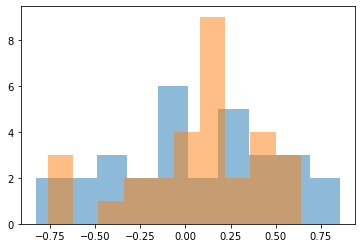

In [42]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad)
#     plt.figure()
    W = to_numpy(param.data)
    plt.hist(W.flatten(),bins=10, alpha=0.5)
#     W /= np.linalg.norm(W, axis=1, keepdims=True)
#     print(W@W.T)
plt.show()

In [43]:
X_s = network.forward(inpt_torch_test)
outpt_val_pred = to_numpy(X_s[-1])
outpt_val_pred.shape

(3, 1000)

In [44]:
# plt.ioff()
# plt.figure()
# df = pd.DataFrame(outpt_val_pred.T, columns=['x','y', 'z'])
# if color is not None:
#     df['target'] = color_test
# fig = px.scatter_3d(df, x='x', y='y', z='z', color='target' if 'target' in df else None)

# fig.show()


In [45]:
# plt.scatter(outpt_val_pred[0], outpt_val_pred[1], c=outpt_test[0])
# plt.show()

In [46]:
# network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

# STOPPING_CRITERION = lambda y_pred, y_true: 1 - get_pred_index(r2_score_torch, -1)(y_pred, y_true)
# VAL_METRICS_REGRESSION = {'r2_score': get_pred_index(r2_score_torch, -1)}
# CRITERION = lambda y_pred, y: -get_k_th_moment(4)(y_pred)

# CRITERION = tsne_criterion #strain
criterion_kwargs = defaultdict(dict)

CRITERION = tsne_criterion
criterion_kwargs['val'] = {'P':P_test_torch, 'perplexity':PERPLEXITY}
criterion_kwargs['train'] = {'perplexity':PERPLEXITY}

T = input_parameters['generator_kwargs']['n_samples']
training_parameters = edict({'learning_type':LEARNING_TYPE,\
                               'lr':1e-3, # learning-rate 
                               'lr_theta':1e-4,
                               'enable_grad_train':True,
                               'enable_grad_val':True,
                               'batch_size':T, # batch-size
                               'tol':1e-2, # loss tolerance for early stopping 
                               'wd':1e-1, # weight-decay
                               'shuffle':True, # shuffle data
                               'progress_bar':True,
                               'weight_saver':None,
                               'calculate_grad':False,
                               'clip_grad_value': None,
                               'stopping_criterion':None,
                               'val_metrics':None,
                               'device':device
                             })

opt = None
if training_parameters['learning_type'] == 'BP': 
    opt = optim.Adam(network.parameters(), 
                     lr=training_parameters.lr,  
                     weight_decay=training_parameters.wd)

metric_dict = None

In [47]:
if opt is not None:
    print(len(opt.param_groups[0]['params']))

2


In [ ]:
training_parameters['learning_type'] = LEARNING_TYPE
training_parameters['batch_size'] = T
training_parameters['epochs'] = 500

network, opt, metric_dict = train(network, 
                                  opt=opt, 
                                  criterion=CRITERION,
                                  train_params=training_parameters,
                                  gata_generator=create_data, 
                                  val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
                                  criterion_kwargs=criterion_kwargs,
                                  metric_dict=metric_dict 
                                  )

 46%|█████████████████████████████████████████████████████████▉                                                                    | 230/500 [05:41<05:50,  1.30s/it]

In [ ]:
# training_parameters['learning_type'] = "BP"
# training_parameters['batch_size'] = T
# training_parameters['epochs'] = 5000


# GRAD_PARAMS = list(filter(lambda x: x.requires_grad, network.parameters()))

# opt = optim.Adam(GRAD_PARAMS, 
#                  lr=training_parameters.lr_theta, 
#                  weight_decay=training_parameters.wd)

# network, opt, metric_dict = train(network, 
#                                   opt=opt, 
#                                   criterion=l2_loss,
#                                   train_params=training_parameters,
#                                   data_params=input_parameters, 
#                                   val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
#                                   metric_dict=metric_dict 
#                                   )

In [ ]:
Z_val_pred = to_numpy(metric_dict['outpt_val'][-1])
outpt_val_pred = to_numpy(metric_dict['outpt_val'][-1])
T_val = outpt_val_pred.shape[1]

plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,4,1)
ax1.plot(metric_dict['criterion_train'])
ax1.set_title('criterion_train')

ax2 = plt.subplot(1,4,2)
ax2.plot(metric_dict['criterion_val'])
ax2.set_title('criterion_val')

plt.tight_layout()
plt.show()

In [ ]:
Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test.T, Z_val_pred.T)

In [ ]:
Q_loc_val_NET, Q_glob_val_NET

In [ ]:
# plt.scatter(Z_val_pred[0], Z_val_pred[1], c=outpt_test[0])
# plt.title("Qloc: {:.2f}, Qglob: {:.2f}".format(Q_loc_val_NET, Q_glob_val_NET))
# plt.show()

In [ ]:
plt.ioff()
plt.figure()
df = pd.DataFrame(np.concatenate([inpt_test, Z_val_pred], axis=1).T, columns=['x','y', 'z'])

df['target'] = np.concatenate([np.zeros((inpt.shape[1])), 
                               np.ones((inpt_test.shape[1]))])

fig = px.scatter_3d(df, x='x', y='y', z='z', color='target')

fig.show()

# Metalearning

### Setup training

In [119]:
network = MLP_NonlinearEncoder(**encoder_parameters).to(device)

T = inpt_data.shape[1]

EPOCHS_HEBB = 10
EPOCH_META = 10
ITER_META = 100

opt = optim.Adam(list(filter(lambda x: x.requires_grad, network.parameters())), \
                           lr=training_parameters.lr_theta, \
                           weight_decay=training_parameters.wd)

### Training

In [120]:
metric_dict = defaultdict(list)
meta_switch_times = defaultdict(list)
ordinary_switch_times = defaultdict(list)

training_parameters['progress_bar'] = False

for meta_iter in tqdm(range(ITER_META)):
    
    meta_switch_times['train'].append(len(metric_dict['loss_train']))
    meta_switch_times['val'].append(len(metric_dict['loss_val']))
    
    # training meta-parameters usign BP
    training_parameters['learning_type'] = "BP"
    training_parameters['batch_size'] = T
    training_parameters['epochs'] = EPOCH_META

    network, opt, metric_dict = train(network, 
                                      opt=opt, 
                                      criterion=l2_loss,
                                      train_params=training_parameters,
                                      data_params=input_parameters, 
                                      val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
                                      metric_dict=metric_dict 
                                      )

    ordinary_switch_times['train'].append(len(metric_dict['loss_train']))
    ordinary_switch_times['val'].append(len(metric_dict['loss_val']))
    
    
    # training connectivity using local rule
    training_parameters['learning_type'] = LEARNING_TYPE
    training_parameters['batch_size'] = 1
    training_parameters['epochs'] = EPOCHS_HEBB

    network, _, metric_dict = train(network, 
                                      opt=None, 
                                      criterion=l2_loss,
                                      train_params=training_parameters,
                                      data_params=input_parameters, 
                                      val_data={'inpt':inpt_torch_test,'outpt':outpt_torch_test},
                                      metric_dict=metric_dict 
                                      )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  5.12s/it]


In [121]:
# f_s_trained = network.f_s

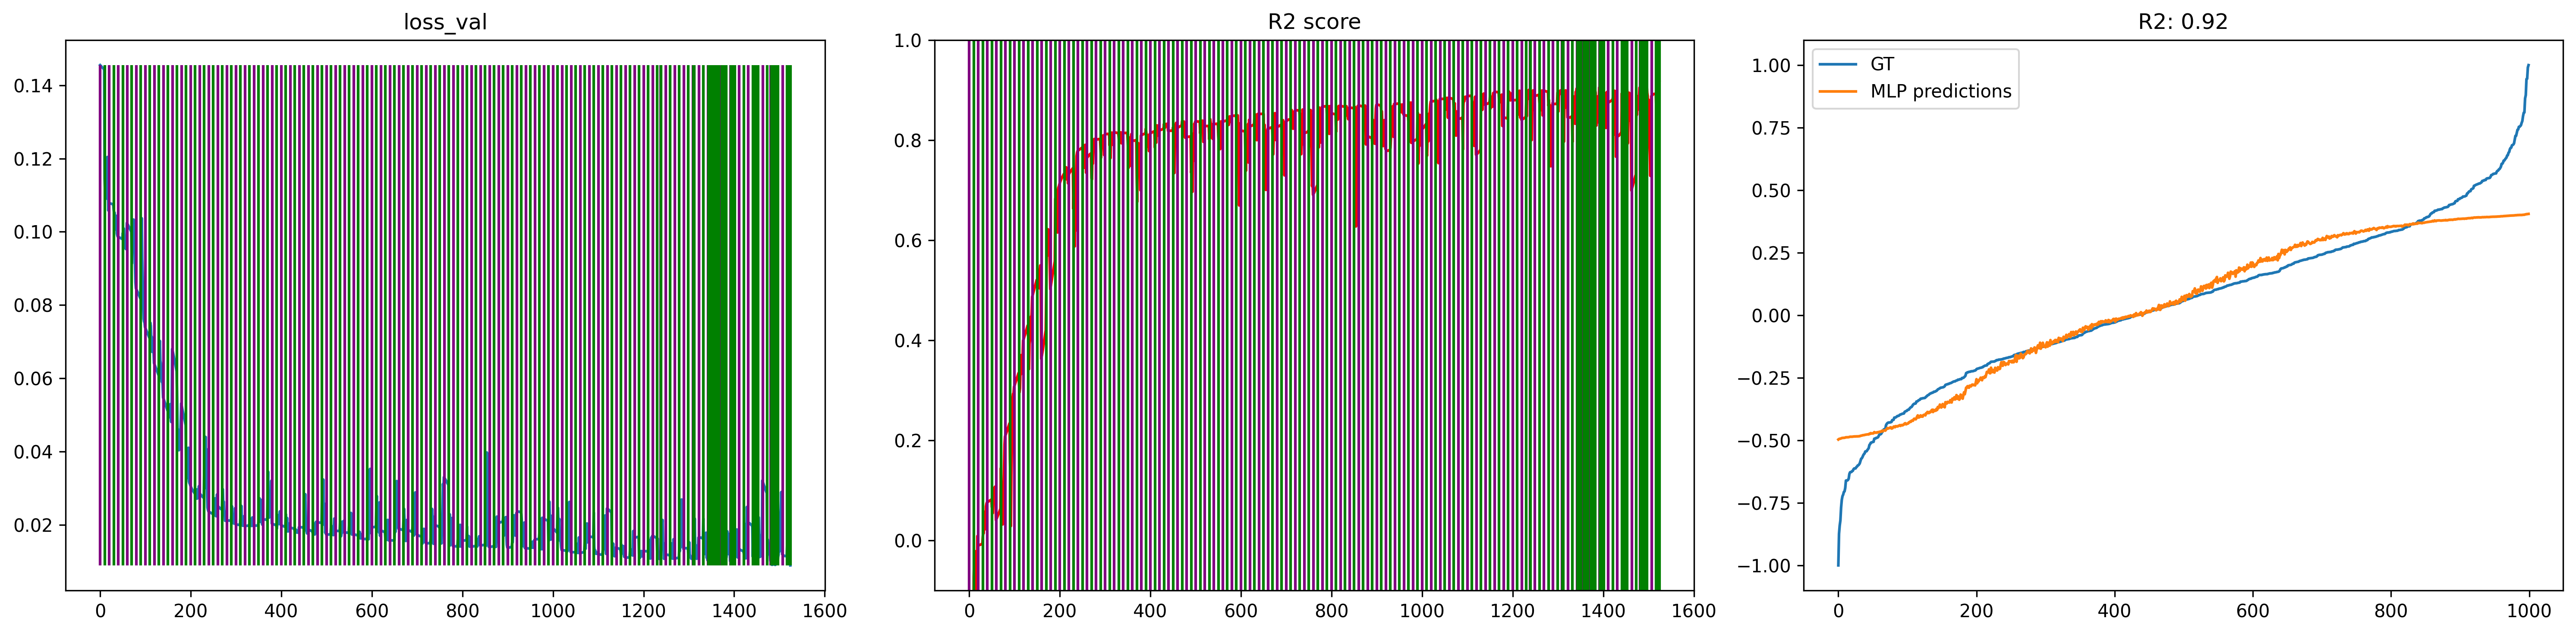

In [126]:
Z_val_pred = to_numpy(metric_dict['outpt_val'][-2])
outpt_val_pred = to_numpy(metric_dict['outpt_val'][-1])
T_val = outpt_val_pred.shape[1]

plt.figure(figsize=(20,5), dpi=300)

ax2 = plt.subplot(1,3,1)
ax2.plot(metric_dict['loss_val'])
#
ax2.vlines(meta_switch_times['val'], \
           min(metric_dict['loss_val']), \
           max(metric_dict['loss_val']), \
           color='purple')

ax2.vlines(ordinary_switch_times['val'], \
           min(metric_dict['loss_val']), \
           max(metric_dict['loss_val']), \
           color='green')
#
ax2.set_title('loss_val')


ax3 = plt.subplot(1,3,2)
ax3.plot(metric_dict['r2_score_val'], color='red')
ax3.set_ylim(-0.1,1)
#
ax3.vlines(meta_switch_times['val'], -0.1, 1, color='purple')
ax3.vlines(ordinary_switch_times['val'], -0.1, 1, color='green')
#
ax3.set_title('R2 score')

ax4 = plt.subplot(1,3,3)
sort_index = np.argsort(outpt_test[0])
r2_val_last = r2_score(outpt_test[0][sort_index], outpt_val_pred[0][sort_index])
ax4.plot(outpt_test[0][sort_index], label='GT')
ax4.plot(outpt_val_pred[0][sort_index], label='MLP predictions')
ax4.set_title('R2: {:.2f}'.format(r2_val_last))
ax4.legend()

plt.tight_layout()
plt.show()

Criterion and BP seem work in different directions

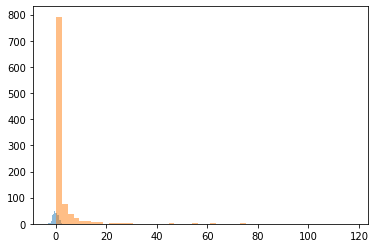

In [74]:
X = np.random.randn(1000)
plt.hist(X, bins=50, alpha=0.5)
plt.hist(X**4, bins=50, alpha=0.5)
plt.show()

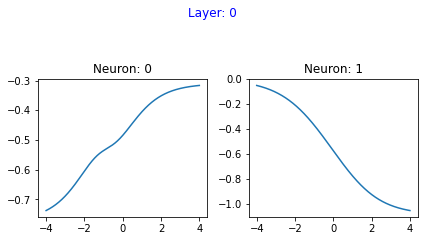

In [123]:
n_fs = len(network.f_s)
ξ = torch.linspace(-4,4,1000).to(device)

for layer in range(n_fs):
    f_theta = network.f_s[layer]
    n_neurons = f_theta.input_dim
    y = torch.stack([ξ for _ in range(n_neurons)],0) # [n_neurons, T]
    
    f = to_numpy(f_theta(y)) # [n_neurons, T]
    
    fig, axes = plt.subplots(ncols=n_neurons, nrows=1, figsize=(n_neurons*3,3))
    
    for j,ax in enumerate(axes):
        ax.plot(to_numpy(ξ), f[j])
        ax.set_title(f'Neuron: {j}')
        
    fig.suptitle(f'Layer: {layer}', y=1.1, color='blue')
    
plt.tight_layout()
plt.show()

In [124]:
Q_loc_val_NET, Q_glob_val_NET = calculate_Q_metrics(inpt_test.T, Z_val_pred.T)

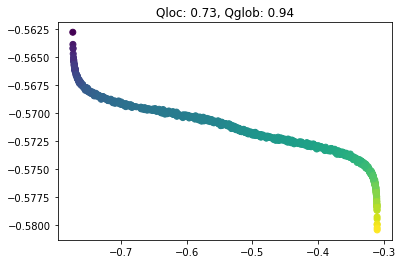

In [125]:
plt.scatter(Z_val_pred[0], Z_val_pred[1], c=outpt_test[0])
plt.title("Qloc: {:.2f}, Qglob: {:.2f}".format(Q_loc_val_NET, Q_glob_val_NET))
plt.show()

In [ ]:
# X = torch.randn(100, requires_grad=True)
# X_argsort = torch.argsort(X)
# X = X[X_argsort]
# k = 3
# y = get_k_th_moment(k)(X) #* X.shape[0]

# dy = torch.autograd.grad(y, 
#                          X, 
#                          retain_graph=True, 
#                          allow_unused=True, 
#                          create_graph=True)[0]

# plt.plot(to_numpy(X))
# plt.plot(to_numpy(dy))
# plt.plot(to_numpy(k*(X**(k-1))))

# plt.ylim(-10,10)